# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
MODEL = "gpt-4o-mini"
openai = OpenAI()

In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [6]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [7]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [8]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [9]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [10]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [11]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [12]:
gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4c - don't go crazy with images!

In [20]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [21]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

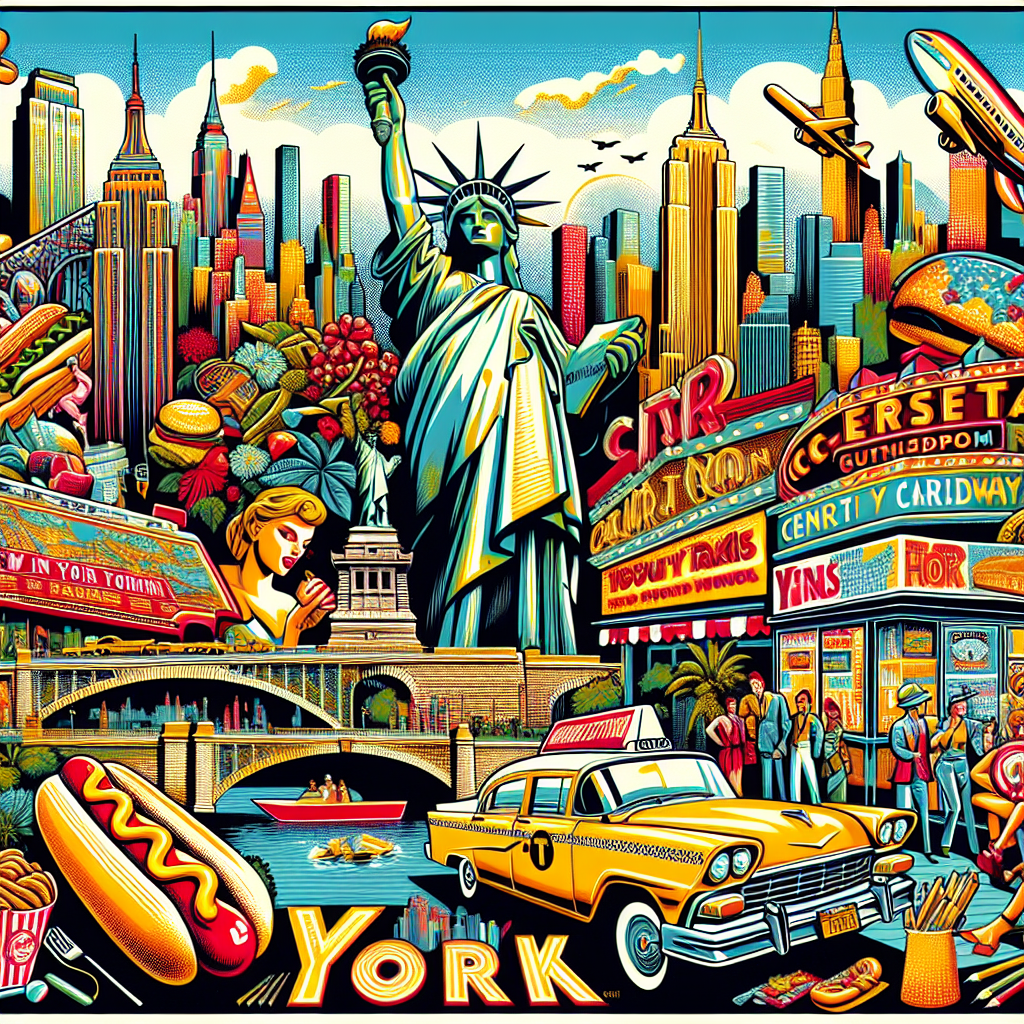

In [22]:
image = artist("New York City")
display(image)

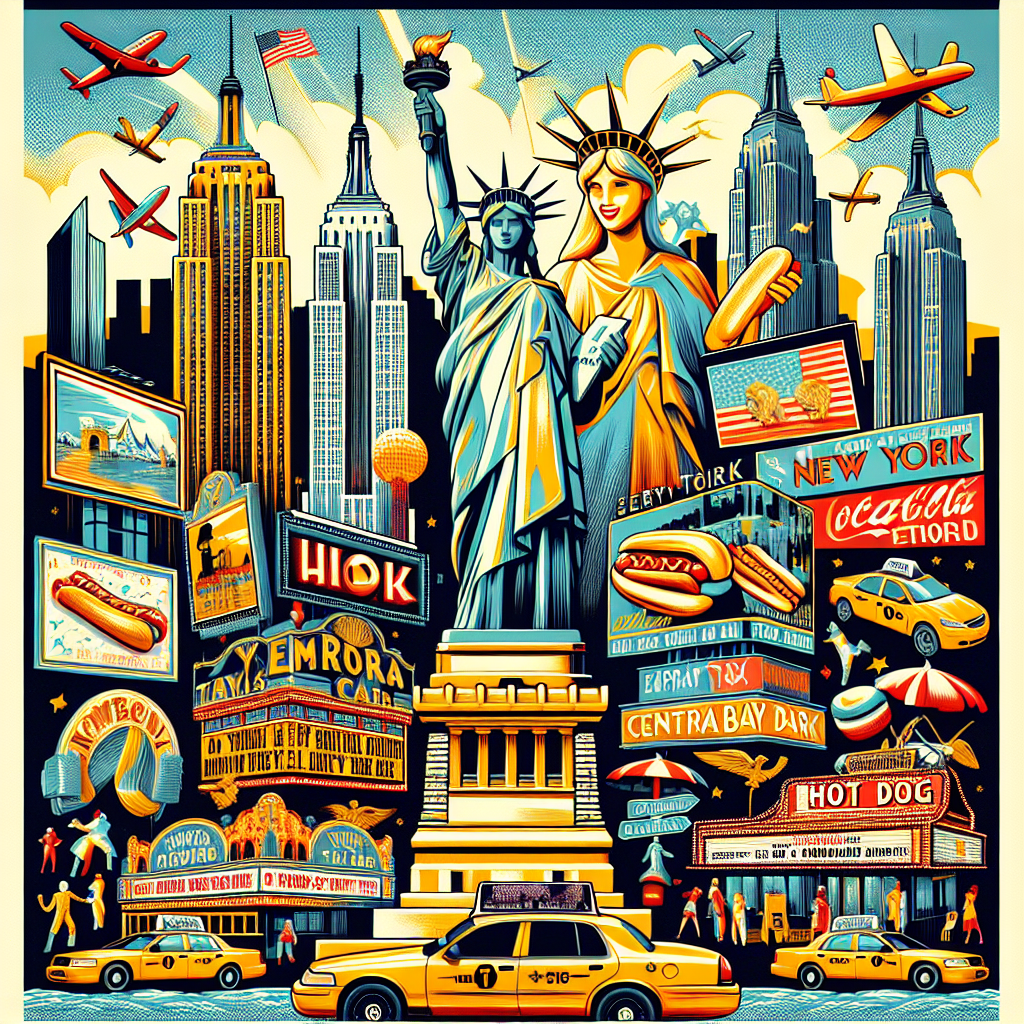

## Audio

And let's make a function talker that uses OpenAI's speech model to generate Audio

In [27]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    #alloy onyx
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [26]:
talker("Well, hi there")

Input #0, wav, from '/var/folders/tl/4_dvbgtd2z142wksgpr03g3h0000gn/T/tmpu6nc_588.wav':
  Duration: 00:00:00.79, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5.

In [28]:
def chat(message, history):
    image = None
    conversation = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        conversation.append({"role": "user", "content": human})
        conversation.append({"role": "assistant", "content": assistant})
    conversation.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=conversation)

    reply = response.choices[0].message.content
    talker(reply)
    return reply, image

In [29]:
# More involved Gradio code as we're not using the preset Chat interface

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)
    with gr.Row():
        msg = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, [chatbot, image_output]
    )
    clear.click(lambda: None, None, chatbot, queue=False)

ui.launch()

Running on local URL:  http://127.0.0.1:7882

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/tl/4_dvbgtd2z142wksgpr03g3h0000gn/T/tmpxglp6v3l.wav':
  Duration: 00:00:02.11, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/tl/4_dvbgtd2z142wksgpr03g3h0000gn/T/tmp90xy_i89.wav':
  Duration: 00:00:05.21, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for London


Input #0, wav, from '/var/folders/tl/4_dvbgtd2z142wksgpr03g3h0000gn/T/tmp1rck0440.wav':
  Duration: 00:00:03.38, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
